# Lottery Ticket Hypothesis: _Conv-4_ CNN for CIFAR10

Implementation of the hypothesis using 4 convolutional layers with the following architecture:

1. __Convolutional Layers:__ 64, 64, pool
1. __Convolutional Layers:__ 128, 128, pool
1. __Dense Layers:__ 256, 256, 10

Filter/Kernel size for convolutional layers is 3 x 3, with padding and stride of 1.

Filter and Stride for max-pooling layers is 2 x 2

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
# from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, ReLU
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal
# import math
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
tf.__version__

'2.0.0'

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [3]:
batch_size = 60
num_classes = 10
num_epochs = 100

In [4]:
# Data preprocessing and cleaning:
# input image dimensions
img_rows, img_cols = 32, 32

# Load CIFAR-10 dataset-
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [5]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

print("\n'input_shape' which will be used = {0}\n".format(input_shape))


'input_shape' which will be used = (32, 32, 3)



In [6]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [7]:
# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [8]:
print("\nDimensions of training and testing sets are:")
print("X_train.shape = {0}, y_train.shape = {1}".format(X_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test.shape = {1}".format(X_test.shape, y_test.shape))


Dimensions of training and testing sets are:
X_train.shape = (50000, 32, 32, 3), y_train.shape = (50000, 10)
X_test.shape = (10000, 32, 32, 3), y_test.shape = (10000, 10)


### Prepare CIFAR10 dataset for _GradientTape_ training:

In [9]:
# Create training and testing datasets-
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [10]:
train_dataset = train_dataset.shuffle(buffer_size = 20000, reshuffle_each_iteration = True).batch(batch_size = batch_size, drop_remainder = False)

In [11]:
test_dataset = test_dataset.batch(batch_size=batch_size, drop_remainder=False)

In [12]:
# Choose an optimizer and loss function for training-
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr = 0.0003)

In [13]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'test_accuracy')

In [14]:
# The model is first trained without any pruning for 'num_epochs' epochs-
epochs = num_epochs

num_train_samples = X_train.shape[0]

end_step = np.ceil(1.0 * num_train_samples / batch_size).astype(np.int32) * epochs

print("'end_step parameter' for this dataset =  {0}".format(end_step))

'end_step parameter' for this dataset =  83400


In [15]:
# Specify the parameters to be used for layer-wise pruning, NO PRUNING is done here:
pruning_params_unpruned = {
    'pruning_schedule': sparsity.ConstantSparsity(
        target_sparsity=0.0, begin_step=0,
        end_step = end_step, frequency=100
    )
}

In [16]:
l = tf.keras.layers

In [17]:
def pruned_nn(pruning_params_conv, pruning_params_fc):
    """
    Function to define the architecture of a neural network model
    following Conv-2 architecture for CIFAR-10 dataset and using
    provided parameter which are used to prune the model.
    
    Conv-4 architecture-
    64, 64, pool  -- convolutions
    128, 128, pool -- convolutions
    256, 256, 10  -- fully connected layers
    
    Input: 'pruning_params' Python 3 dictionary containing parameters which are used for pruning
    Output: Returns designed and compiled neural network model
    """
    
    pruned_model = Sequential()
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same',
            input_shape=(32, 32, 3)
        ),
        **pruning_params_conv)
    )
        
    pruned_model.add(sparsity.prune_low_magnitude(
        Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        ),
        **pruning_params_conv)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        ),
        **pruning_params_conv)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Conv2D(
            filters = 128, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        ),
        **pruning_params_conv)
    )

    pruned_model.add(sparsity.prune_low_magnitude(
        Conv2D(
            filters = 128, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        ),
        **pruning_params_conv)
    )

    pruned_model.add(sparsity.prune_low_magnitude(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        ),
        **pruning_params_conv)
    )

    
    pruned_model.add(Flatten())
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(
            units = 256, activation='relu',
            kernel_initializer = tf.initializers.GlorotUniform()
        ),
        **pruning_params_fc)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(
            units = 256, activation='relu',
            kernel_initializer = tf.initializers.GlorotUniform()
        ),
        **pruning_params_fc)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(
            units = 10, activation='softmax'
        ),
        **pruning_params_fc)
    )
    

    # Compile pruned CNN-
    pruned_model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        # optimizer='adam',
        optimizer=tf.keras.optimizers.Adam(lr = 0.0003),
        metrics=['accuracy']
    )
    
    
    return pruned_model


In [18]:
# Add a pruning step callback to peg the pruning step to the optimizer's
# step. Also add a callback to add pruning summaries to tensorboard
callback = [
             sparsity.UpdatePruningStep(),
             # sparsity.PruningSummaries(log_dir = logdir, profile_batch=0),
             tf.keras.callbacks.EarlyStopping(
                 monitor='val_loss', patience = 3,
                 min_delta=0.001
             )
]

In [19]:
# Initialize a CNN model-
orig_model = pruned_nn(pruning_params_unpruned, pruning_params_unpruned)

Instructions for updating:
Please use `layer.add_weight` method instead.


In [20]:
# Strip model of it's pruning parameters
orig_model_stripped = sparsity.strip_pruning(orig_model)

In [21]:
# Save random weights-
orig_model.save_weights("Conv_4_CIFAR_Ramdom_Weights.h5", overwrite=True)

In [22]:
# Save random weights-
orig_model.save_weights("Conv_4_CIFAR_Winning_Ticket.h5", overwrite=True)

In [23]:
# Get CNN summary-
orig_model_stripped.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

### Layer-wise pruning:
The Lottery Ticket Hypothesis follows a _layer-wise pruning_ heuristic, where the fully-connected (fc) layers are pruned at the rate of 20% per iterative
pruning round and the convolutional (conv) layers are pruned at the rate of 10% per iterative pruning round.

Therefore, there is a need to compute the percentage of weights being pruned for each layer.

In [24]:
# number of convolutional parameters-
conv1 = 1792
conv2 = 36928
conv3 = 73856
conv4 = 147584


# number of fully-connected dense parameters-
dense1 = 2097408
dense2 = 65792
op_layer = 2570


# total number of parameters-
total_params = conv1 + conv2 + conv3 + conv4 + dense1 + dense2 + op_layer

print("\nTotal number of trainable parameters = {0}\n".format(total_params))


Total number of trainable parameters = 2425930



In [25]:
# maximum pruning performed is till 0.5% of all parameters-
max_pruned_params = 0.005 * total_params

In [26]:
loc_tot_params = total_params
loc_conv1 = conv1
loc_conv2 = conv2
loc_conv3 = conv3
loc_conv4 = conv4
loc_dense1 = dense1
loc_dense2 = dense2
loc_op_layer = op_layer


# variable to count number of pruning rounds-
n = 0

In [27]:
# Lists to hold percentage of weights pruned in each round for all layers in CNN-
conv1_pruning = []
conv2_pruning = []
conv3_pruning = []
conv4_pruning = []
dense1_pruning = []
dense2_pruning = []
op_layer_pruning = []


In [28]:
while loc_tot_params >= max_pruned_params:
    loc_conv1 *= 0.9    # 10% weights are pruned
    loc_conv2 *= 0.9    # 10% weights are pruned
    loc_conv3 *= 0.9	# 10% weights are pruned
    loc_conv4 *= 0.9	# 10% weights are pruned
    loc_dense1 *= 0.8   # 20% weights are pruned
    loc_dense2 *= 0.8   # 20% weights are pruned
    loc_op_layer *= 0.8 # 20% weights are pruned

    conv1_pruning.append(((conv1 - loc_conv1) / conv1) * 100)
    conv2_pruning.append(((conv2 - loc_conv2) / conv2) * 100)
    conv3_pruning.append(((conv3 - loc_conv3) / conv3) * 100)
    conv4_pruning.append(((conv4 - loc_conv4) / conv4) * 100)
    dense1_pruning.append(((dense1 - loc_dense1) / dense1) * 100)
    dense2_pruning.append(((dense2 - loc_dense2) / dense2) * 100)
    op_layer_pruning.append(((op_layer - loc_op_layer) / op_layer) * 100)

    loc_tot_params = loc_conv1 + loc_conv2 + loc_conv3 + loc_conv4 + loc_dense1 + \
    loc_dense2 + loc_op_layer

    n += 1

    print("\nConv1 = {0:.3f}, Conv2 = {1:.3f}".format(loc_conv1, loc_conv2))
    print("Dense1 = {0:.3f}, Dense2 = {1:.3f} & O/p layer = {2:.3f}".format(
        loc_dense1, loc_dense2, loc_op_layer))
    print("Total number of parameters = {0:.3f}\n".format(loc_tot_params))




Conv1 = 1612.800, Conv2 = 33235.200
Dense1 = 1677926.400, Dense2 = 52633.600 & O/p layer = 2056.000
Total number of parameters = 1966760.000


Conv1 = 1451.520, Conv2 = 29911.680
Dense1 = 1342341.120, Dense2 = 42106.880 & O/p layer = 1644.800
Total number of parameters = 1596822.400


Conv1 = 1306.368, Conv2 = 26920.512
Dense1 = 1073872.896, Dense2 = 33685.504 & O/p layer = 1315.840
Total number of parameters = 1298530.880


Conv1 = 1175.731, Conv2 = 24228.461
Dense1 = 859098.317, Dense2 = 26948.403 & O/p layer = 1052.672
Total number of parameters = 1057790.368


Conv1 = 1058.158, Conv2 = 21805.615
Dense1 = 687278.653, Dense2 = 21558.723 & O/p layer = 842.138
Total number of parameters = 863301.392


Conv1 = 952.342, Conv2 = 19625.053
Dense1 = 549822.923, Dense2 = 17246.978 & O/p layer = 673.710
Total number of parameters = 706003.301


Conv1 = 857.108, Conv2 = 17662.548
Dense1 = 439858.338, Dense2 = 13797.582 & O/p layer = 538.968
Total number of parameters = 578628.610


Conv1 = 77

In [29]:
print("\nnumber of pruning rounds = {0}\n\n".format(n))


number of pruning rounds = 31




In [30]:
num_pruning_rounds = n

In [31]:
# Convert from list to np.array-
conv1_pruning = np.array(conv1_pruning)
conv2_pruning = np.array(conv2_pruning)
conv3_pruning = np.array(conv3_pruning)
conv4_pruning = np.array(conv4_pruning)
dense1_pruning = np.array(dense1_pruning)
dense2_pruning = np.array(dense2_pruning)
op_layer_pruning = np.array(op_layer_pruning)


In [32]:
# Round off numpy arrays to 3 decimal digits-
conv1_pruning = np.round(conv1_pruning, decimals=3)
conv2_pruning = np.round(conv2_pruning, decimals=3)
conv3_pruning = np.round(conv3_pruning, decimals = 3)
conv4_pruning = np.round(conv4_pruning, decimals = 3)
dense1_pruning = np.round(dense1_pruning, decimals=3)
dense2_pruning = np.round(dense2_pruning, decimals=3)
op_layer_pruning = np.round(op_layer_pruning, decimals=3)


In [33]:
# Sanity check-
conv1_pruning

array([10.   , 19.   , 27.1  , 34.39 , 40.951, 46.856, 52.17 , 56.953,
       61.258, 65.132, 68.619, 71.757, 74.581, 77.123, 79.411, 81.47 ,
       83.323, 84.991, 86.491, 87.842, 89.058, 90.152, 91.137, 92.023,
       92.821, 93.539, 94.185, 94.767, 95.29 , 95.761, 96.185])

### NOTE:

Make sure that the pruning rates are between 0 and 1 for _TensorFlow Pruning_ to work

In [34]:
conv1_pruning = conv1_pruning / 100
conv2_pruning = conv2_pruning / 100
conv3_pruning = conv3_pruning / 100
conv4_pruning = conv4_pruning / 100
dense1_pruning = dense1_pruning / 100
dense2_pruning = dense2_pruning / 100
op_layer_pruning = op_layer_pruning / 100


In [35]:
# Sanity check-
# np.all(conv1_pruning == conv4_pruning)
dense1_pruning

array([0.2    , 0.36   , 0.488  , 0.5904 , 0.67232, 0.73786, 0.79028,
       0.83223, 0.86578, 0.89263, 0.9141 , 0.93128, 0.94502, 0.95602,
       0.96482, 0.97185, 0.97748, 0.98199, 0.98559, 0.98847, 0.99078,
       0.99262, 0.9941 , 0.99528, 0.99622, 0.99698, 0.99758, 0.99807,
       0.99845, 0.99876, 0.99901])

### Create a mask:
A mask is created where all parameters equal to one.

This will be used later by _GradientTape_ for training the defined neural network.

In [36]:
# Instantiate a new neural network model for which, the mask is to be created,
# according to the paper-
mask_model = pruned_nn(pruning_params_unpruned, pruning_params_unpruned)

In [37]:
# Strip the model of its pruning parameters-
mask_model_stripped = sparsity.strip_pruning(mask_model)

In [38]:
# Assign all masks to one-

for wts in mask_model_stripped.trainable_weights:
    wts.assign(
        tf.ones_like(
            input = wts,
            dtype = tf.float32
        )

    )
    # wts.assign(1.)
    # wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))

In [39]:
print("\nMask model metrics:")
print("layer-wise number of nonzero parameters in each layer are: \n")

masked_sum_params = 0

for layer in mask_model_stripped.trainable_weights:
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    masked_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal number of trainable parameters = {0}\n".format(masked_sum_params))


Mask model metrics:
layer-wise number of nonzero parameters in each layer are: 

1728
64
36864
64
73728
128
147456
128
2097152
256
65536
256
2560
10

Total number of trainable parameters = 2425930



In [40]:
print("\nnumber of pruning rounds for Conv-4 CNN = {0} and number of epochs = {1}\n".format(num_pruning_rounds, num_epochs))


number of pruning rounds for Conv-4 CNN = 31 and number of epochs = 100



In [41]:
orig_sum_params = total_params
print("orig_sum_params = ", orig_sum_params)

orig_sum_params =  2425930


### Python 3 dictionary to hold model training metrics for each of _n_ rounds:

In [42]:
# Method - 1: Nested Python 3 dictionaries:
history_main = {}

# for x in range(num_pruning_rounds + 1):
for x in range(num_pruning_rounds):
    history = {}
    
    # CNN model, scalar metrics-
    history['accuracy'] = np.zeros(shape = num_epochs)
    history['val_accuracy'] = np.zeros(shape = num_epochs)
    history['loss'] = np.zeros(shape = num_epochs)
    history['val_loss'] = np.zeros(shape = num_epochs)
    
    # compute % of weights pruned at the end of each iterative pruning round-
    history['percentage_wts_pruned'] = 90
    
    # history['epoch_length'] = np.zeros(shape = num_epochs)

    history_main[x + 1] = history


In [43]:
# Sanity check-
history_main.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [44]:
# Sanity check-
history_main[2].keys()

dict_keys(['accuracy', 'val_accuracy', 'loss', 'val_loss', 'percentage_wts_pruned'])

In [45]:
# Sanity check-
history_main[10]['accuracy'].shape

(100,)

In [46]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 3

In [47]:
best_val_loss = 100
loc_patience = 0

In [ ]:
for i in range(1, num_pruning_rounds + 1):
    
    print("\n\n\nIterative pruning round: {0}\n\n".format(i))
    
    # Define 'train_one_step()' and 'test_step()' functions here-
    @tf.function
    def train_one_step(model, mask_model, optimizer, x, y):
        '''
        Function to compute one step of gradient descent optimization
        '''
        with tf.GradientTape() as tape:
            # Make predictions using defined model-
            y_pred = model(x)

            # Compute loss-
            loss = loss_fn(y, y_pred)
        
        # Compute gradients wrt defined loss and weights and biases-
        grads = tape.gradient(loss, model.trainable_variables)
    
        # type(grads)
        # list
    
        # List to hold element-wise multiplication between-
        # computed gradient and masks-
        grad_mask_mul = []
    
        # Perform element-wise multiplication between computed gradients and masks-
        for grad_layer, mask in zip(grads, mask_model.trainable_weights):
            grad_mask_mul.append(tf.math.multiply(grad_layer, mask))
    
        # Apply computed gradients to model's weights and biases-
        optimizer.apply_gradients(zip(grad_mask_mul, model.trainable_variables))

        # Compute accuracy-
        train_loss(loss)
        train_accuracy(y, y_pred)

        return None
    
    
    @tf.function
    def test_step(model, optimizer, data, labels):
        """
        Function to test model performance
        on testing dataset
        """
    
        predictions = model(data)
        t_loss = loss_fn(labels, predictions)

        test_loss(t_loss)
        test_accuracy(labels, predictions)

        return None


    # Instantiate a model
    model_gt = pruned_nn(pruning_params_unpruned, pruning_params_unpruned)
    
    # Load winning ticket (from above)-
    model_gt.load_weights("Conv_4_CIFAR_Winning_Ticket.h5")
    
    # Strip model of pruning parameters-
    model_gt_stripped = sparsity.strip_pruning(model_gt)
    
    
    # Train model using 'GradientTape'-
    
    # Initialize parameters for Early Stopping manual implementation-
    best_val_loss = 100
    loc_patience = 0
    
    for epoch in range(num_epochs):
    
        if loc_patience >= patience:
            print("\n'EarlyStopping' called!\n")
            break
        
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()
        
            
        for x, y in train_dataset:
            # train_one_step(model_gt_stripped, mask_model, optimizer, x, y, grad_mask_mul)
            train_one_step(model_gt_stripped, mask_model_stripped, optimizer, x, y)


        for x_t, y_t in test_dataset:
            # test_step(x_t, y_t)
            test_step(model_gt_stripped, optimizer, x_t, y_t)

        template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'
    
        # 'i' is the index for number of pruning rounds-
        history_main[i]['accuracy'][epoch] = train_accuracy.result() * 100
        history_main[i]['loss'][epoch] = train_loss.result()
        history_main[i]['val_loss'][epoch] = test_loss.result()
        history_main[i]['val_accuracy'][epoch] = test_accuracy.result() * 100
        
        print(template.format(epoch + 1, 
                              train_loss.result(), train_accuracy.result()*100,
                              test_loss.result(), test_accuracy.result()*100))
    
        # Count number of non-zero parameters in each layer and in total-
        # print("layer-wise manner model, number of nonzero parameters in each layer are: \n")

        model_sum_params = 0
    
        for layer in model_gt_stripped.trainable_weights:
            # print(tf.math.count_nonzero(layer, axis = None).numpy())
            model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
        print("Total number of trainable parameters = {0}\n".format(model_sum_params))

    
        # Code for manual Early Stopping:
        if np.abs(test_loss.result() < best_val_loss) >= minimum_delta:
            # update 'best_val_loss' variable to lowest loss encountered so far-
            best_val_loss = test_loss.result()
        
            # reset 'loc_patience' variable-
            loc_patience = 0
        
        else:  # there is no improvement in monitored metric 'val_loss'
            loc_patience += 1  # number of epochs without any improvement

    
    # Resize numpy arrays according to the epoch when 'EarlyStopping' was called-
    for metrics in history_main[i].keys():
        history_main[i][metrics] = np.resize(history_main[i][metrics], new_shape = epoch)
        # history[metrics] = np.resize(history[metrics], new_shape=epoch)
    
        
    # Save trained model weights-
    model_gt.save_weights("Conv_4_CIFAR_Trained_Weights.h5", overwrite=True)
    
    
    
    
    # Prune trained model:
    
    # print("\n% of weights to be pruned in round = {0} is: {1:.4f}\n".format(i, wts_np[i - 1]))
    
    # Specify the parameters to be used for layer-wise pruning, Conv layer-
    pruning_params_conv = {
        'pruning_schedule': sparsity.ConstantSparsity(
            target_sparsity=conv1_pruning[i - 1], begin_step = 1000,
            end_step = end_step, frequency=100
        )
    }

    
    # Specify the parameters to be used for layer-wise pruning, Fully-Connected layer pruning-
    pruning_params_fc = {
        'pruning_schedule': sparsity.ConstantSparsity(
            target_sparsity=dense1_pruning[i - 1], begin_step = 1000,
            end_step = end_step, frequency=100
        )
    }
    
    
    # Instantiate a Nueal Network model to be pruned using parameters from above-
    pruned_model = pruned_nn(pruning_params_conv, pruning_params_fc)
    
    # Load weights from original trained and unpruned model-
    pruned_model.load_weights("Conv_4_CIFAR_Trained_Weights.h5")
    
    # Train pruned NN-
    history_pruned = pruned_model.fit(
        x = X_train, y = y_train,
        batch_size = batch_size,
        epochs = epochs,
        verbose = 1,
        callbacks = callback,
        validation_data = (X_test, y_test),
        shuffle = True
    )
    
    # Strip the pruning wrappers from pruned model-
    pruned_model_stripped = sparsity.strip_pruning(pruned_model)
    
    # print("\nIn pruned model, number of nonzero parameters in each layer are: \n")
    pruned_sum_params = 0
    
    for layer in pruned_model_stripped.trainable_weights:
        # print(tf.math.count_nonzero(layer, axis = None).numpy())
        pruned_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
    print("\nRound = {0}, total number of trainable parameters = {1}\n".format(i, pruned_sum_params))
    # print("\nTotal number of trainable parameters = {0}\n".format(pruned_sum_params))
    
    '''
    # Sanity-check: confirm that the weights are actually pruned away from the network-
    print("\nRound = {0}, % of weights pruned away = {1:.2f}%\n".format( \
                                                i, (orig_sum_params - pruned_sum_params) / orig_sum_params * 100))
    '''
    
    # 'i' is the index for number of pruning rounds-
    history_main[i]['percentage_wts_pruned'] = ((orig_sum_params - pruned_sum_params) / orig_sum_params) * 100
    
    
    # Save weights of PRUNED and Trained model BEFORE stripping-
    pruned_model.save_weights("Conv_4_CIFAR_Pruned_Weights.h5", overwrite = True)
    
    
    # Create a mask:
    
    # Instantiate a new neural network model for which, the mask is to be created,
    mask_model = pruned_nn(pruning_params_unpruned, pruning_params_unpruned)
    
    # Load weights of PRUNED model-
    mask_model.load_weights("Conv_4_CIFAR_Pruned_Weights.h5")
    
    # Strip the model of its pruning parameters-
    mask_model_stripped = sparsity.strip_pruning(mask_model)
    
    # For each layer, for each weight which is 0, leave it, as is.
    # And for weights which survive the pruning,reinitialize it to ONE (1)-
    for wts in mask_model_stripped.trainable_weights:
        wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))
    
    
    
    
    # Extract Winning Ticket:
    
    # Instantiate a new neural network model for which, the weights are to be extracted-
    winning_ticket_model = pruned_nn(pruning_params_unpruned, pruning_params_unpruned)
    
    # Load weights of PRUNED model-
    winning_ticket_model.load_weights("Conv_4_CIFAR_Pruned_Weights.h5")
    
    # Strip the model of its pruning parameters-
    winning_ticket_model_stripped = sparsity.strip_pruning(winning_ticket_model)
    
    # For each layer, for each weight which is 0, leave it, as is. And for weights which survive the pruning,
    # reinitialize it to the value, the model received BEFORE it was trained and pruned-
    for orig_wts, pruned_wts in zip(orig_model_stripped.trainable_weights,
                                    winning_ticket_model_stripped.trainable_weights):
        pruned_wts.assign(tf.where(tf.equal(pruned_wts, 0), pruned_wts, orig_wts))
    
    
    # Save the weights (with pruning parameters) extracted to a file-
    winning_ticket_model.save_weights("Conv_4_CIFAR_Winning_Ticket.h5", overwrite=True)
    
    # Write message to log file:
    with open("/home/majumdar/The_Lottery_Ticket_Hypothesis-Resources/Conv4_log_file.txt", "a+") as f:
        f.write("Completed iterative pruning round: {0}\n".format(i))
    
    
    




Iterative pruning round: 1


Epoch 1, Loss: 1.4409, Accuracy: 47.5380, Test Loss: 1.2378, Test Accuracy: 55.519997
Total number of trainable parameters = 2425928

Epoch 2, Loss: 0.9642, Accuracy: 65.9160, Test Loss: 0.8783, Test Accuracy: 69.110001
Total number of trainable parameters = 2425929

Epoch 3, Loss: 0.7616, Accuracy: 73.5060, Test Loss: 0.7962, Test Accuracy: 72.459999
Total number of trainable parameters = 2425930

Epoch 4, Loss: 0.6164, Accuracy: 78.4480, Test Loss: 0.7439, Test Accuracy: 74.650002
Total number of trainable parameters = 2425930

Epoch 5, Loss: 0.4885, Accuracy: 82.7500, Test Loss: 0.7221, Test Accuracy: 75.820000
Total number of trainable parameters = 2425930

Epoch 6, Loss: 0.3606, Accuracy: 87.3020, Test Loss: 0.7420, Test Accuracy: 76.790001
Total number of trainable parameters = 2425930

Epoch 7, Loss: 0.2518, Accuracy: 91.2360, Test Loss: 0.7911, Test Accuracy: 76.990005
Total number of trainable parameters = 2425930

Epoch 8, Loss: 0.1671, Accurac

In [57]:
print("\nIterative-pruning for Conv-4 CNN using Lottery Ticket Hypothesis is now complete.\n")


Iterative-pruning for Conv-4 CNN using Lottery Ticket Hypothesis is now complete.



In [ ]:
import os
import pickle

In [ ]:
os.getcwd()

In [58]:
with open("/home/majumdar/The_Lottery_Ticket_Hypothesis-Resources/Conv4_CIFAR10_history_main_Experiment_3.pkl", "wb") as f:
    pickle.dump(history_main, f)

### Finding _winning ticket_:

A _winning ticket_ is a sub-network which has:

1. equivalent or higher _validation accuracy_
1. equivalent or lower _number of epochs (using early stopping_)
1. maximum possible percentage of weights pruned

as compared to the original, over-parametrized, unpruned convolutional neural network.

In [59]:
base_accuracy = 0
base_num_epochs = 0


base_num_epochs = len(history_main[1]['loss'])
base_accuracy = history_main[1]['val_accuracy'][base_num_epochs - 1]

base_accuracy

print("\nbase accuracy = {0:.4f}% & base number of epochs = {1}\n".format(base_accuracy, base_num_epochs))



base accuracy = 76.2500% & base number of epochs = 8



In [93]:
best_accuracy = base_accuracy
best_num_epochs = base_num_epochs
best_wts = 100


In [94]:
# NOTE: A winning ticket has 'maximum' amount of % of weights pruned-

for k in history_main.keys():
    num_epochs = len(history_main[k]['loss'])
    if history_main[k]['val_accuracy'][num_epochs - 1] >= best_accuracy and num_epochs <= best_num_epochs:
        best_accuracy = history_main[k]['val_accuracy'][num_epochs - 1]
        best_num_epochs = num_epochs
        best_wts = history_main[k]['percentage_wts_pruned']

print("\nbest accuracy = {0:.4f}%, best number of epochs = {1} & % of weights pruned = {2:.4f}%\n".format(best_accuracy, best_num_epochs, best_wts))


best accuracy = 76.2500%, epochs = 8 & % wts = 18.9217%
best accuracy = 77.5300%, epochs = 8 & % wts = 34.1662%
best accuracy = 77.8100%, epochs = 7 & % wts = 46.4581%
best accuracy = 77.9200%, epochs = 7 & % wts = 56.3784%
best accuracy = 78.3000%, epochs = 5 & % wts = 70.8759%

best accuracy = 78.3000%, best number of epochs = 5 & % of weights pruned = 70.8759%



In [62]:
# For cross-checking, tally results received from above with this, manually-
for k in history_main.keys():
    print("\nRound = {0}, % of wts pruned = {1:.4f}%".format(k, history_main[k]['percentage_wts_pruned']))
    print("val_accuracy: {0}\n".format(history_main[k]['val_accuracy']))



Round = 1, % of wts pruned = 18.9217%
val_accuracy: [55.51999664 69.11000061 72.45999908 74.65000153 75.81999969 76.79000092
 76.99000549 76.25      ]


Round = 2, % of wts pruned = 34.1662%
val_accuracy: [62.76000214 71.41999817 74.31999969 75.31999969 77.38000488 77.1700058
 77.56999969 77.52999878]


Round = 3, % of wts pruned = 46.4581%
val_accuracy: [65.80999756 71.84999847 73.88999939 75.73999786 75.94000244 77.05000305
 77.80999756]


Round = 4, % of wts pruned = 56.3784%
val_accuracy: [69.59999847 73.68000031 76.40000153 76.77000427 77.43000031 78.08000183
 77.91999817]


Round = 5, % of wts pruned = 64.3931%
val_accuracy: [69.09999847 75.13999939 76.70000458 77.04000092 78.26999664 78.05000305
 77.47000122]


Round = 6, % of wts pruned = 70.8759%
val_accuracy: [71.72000122 76.15000153 76.56000519 76.68000031 78.30000305]


Round = 7, % of wts pruned = 76.1240%
val_accuracy: [73.04999542 75.87000275 75.5        77.         77.97000122]


Round = 8, % of wts pruned = 80.3812%
v

### Visualizations for _Iterative Pruning Rounds_:

In [63]:
# Python 3 dict for training and testing accuracy visualization-
# key is 'percentage_wts_pruned' and value is accuracy
plot_accuracy = {}
plot_test_accuracy = {}

In [64]:
# populate 'plot_accuracy'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['accuracy'])
    plot_accuracy[history_main[k]['percentage_wts_pruned']] = history_main[k]['accuracy'][epoch_length - 1]

In [65]:
# populate 'plot_test_accuracy'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['accuracy'])
    plot_test_accuracy[history_main[k]['percentage_wts_pruned']] = history_main[k]['val_accuracy'][epoch_length - 1]


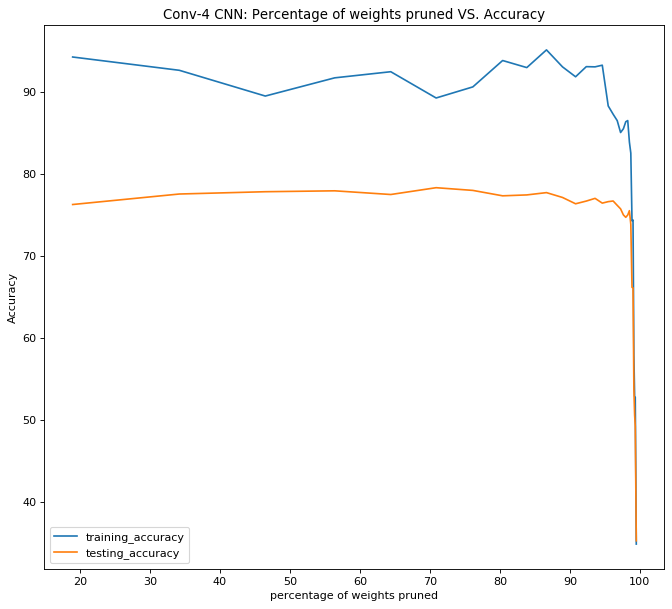

In [66]:
# Visualization of training and testing accuracy VS percentage of weights
# pruned-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_accuracy.keys()), list(plot_accuracy.values()), label = 'training_accuracy')
plt.plot(list(plot_test_accuracy.keys()), list(plot_test_accuracy.values()), label = 'testing_accuracy')

plt.title("Conv-4 CNN: Percentage of weights pruned VS. Accuracy")
plt.xlabel("percentage of weights pruned")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')
plt.show()

In [67]:
# Python 3 dict for training and testing loss visualization-
plot_loss = {}
plot_test_loss = {}

In [68]:
# populate 'plot_loss'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_loss[history_main[k]['percentage_wts_pruned']] = history_main[k]['loss'][epoch_length - 1]


In [69]:
# populate 'plot_test_loss'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_test_loss[history_main[k]['percentage_wts_pruned']] = history_main[k]['val_loss'][epoch_length - 1]


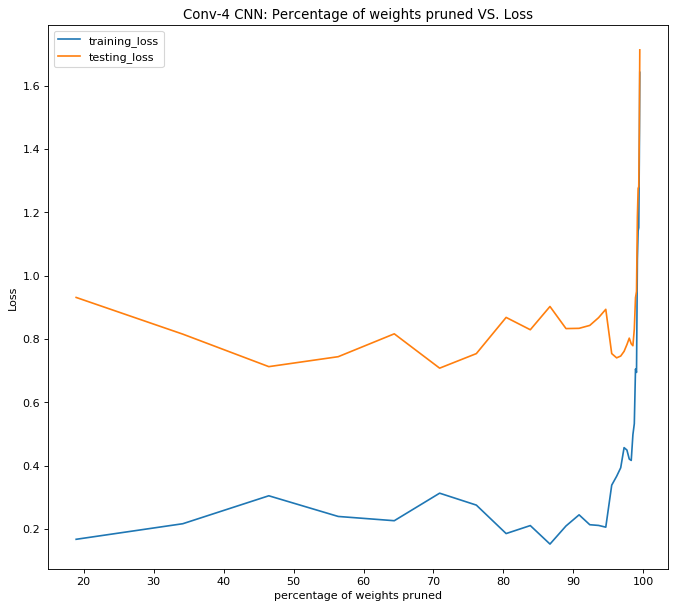

In [70]:
# Visualization of training and testing loss VS percentage of remaining weights-
# pruned-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_loss.keys()), list(plot_loss.values()), label = 'training_loss')
plt.plot(list(plot_test_loss.keys()), list(plot_test_loss.values()), label = 'testing_loss')

plt.title("Conv-4 CNN: Percentage of weights pruned VS. Loss")
plt.xlabel("percentage of weights pruned")
plt.ylabel("Loss")
plt.legend(loc = 'best')
plt.show()

In [71]:
# Plot number of epochs (Early Stopping) VS percentage of weights pruned-

# Python 3 dict to hold number of epochs vs % of weights pruned-
# Experiment-1
plot_num_epochs = {}
# plot_num_epochs_test = {}

# populate 'plot_num_epochs'-
for k in history_main.keys():
    num_epochs = len(history_main[k]['accuracy'])
    plot_num_epochs[history_main[k]['percentage_wts_pruned']] = num_epochs


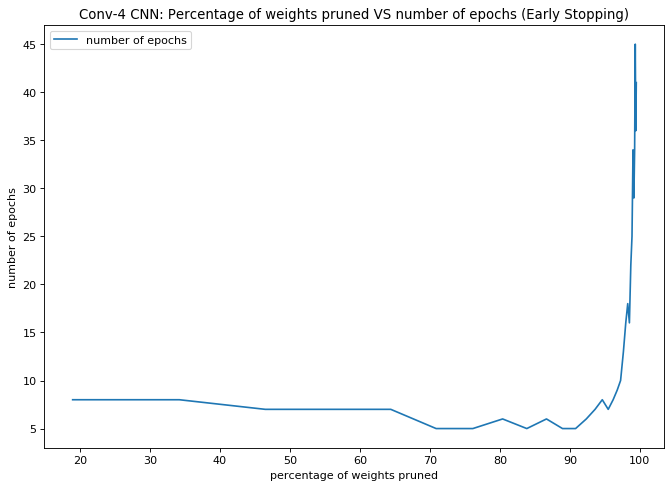

In [72]:
# Visualize percentage of weights remaining VS number of epochs (Early Stopping)
fig=plt.figure(figsize=(10, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_num_epochs.keys()), list(plot_num_epochs.values()), label = 'number of epochs')
# plt.plot(list(plot_test_accuracy.keys()), list(plot_test_accuracy.values()), label = 'validation accuracy')
# plt.plot(list(plot_test_loss.keys()), list(plot_test_loss.values()), label = 'validation loss')

plt.title("Conv-4 CNN: Percentage of weights pruned VS number of epochs (Early Stopping)")
plt.xlabel("percentage of weights pruned")
plt.ylabel("number of epochs")
plt.legend(loc = 'best')
plt.show()


In [73]:
# Try to visualize the STARTING training and testing accuracy VS percentage
# of remaining weights-

# Python 3 dict for visualization-
plot_starting_accuracy = {}
plot_starting_test_accuracy = {}

# Key:    percentage of weights pruned
# Value:  starting accuracy


In [74]:
# populate 'plot_starting_accuracy'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_starting_accuracy[history_main[k]['percentage_wts_pruned']] = history_main[k]['accuracy'][0]


In [75]:
# populate 'plot_starting_test_accuracy'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_starting_test_accuracy[history_main[k]['percentage_wts_pruned']] = history_main[k]['val_accuracy'][0]


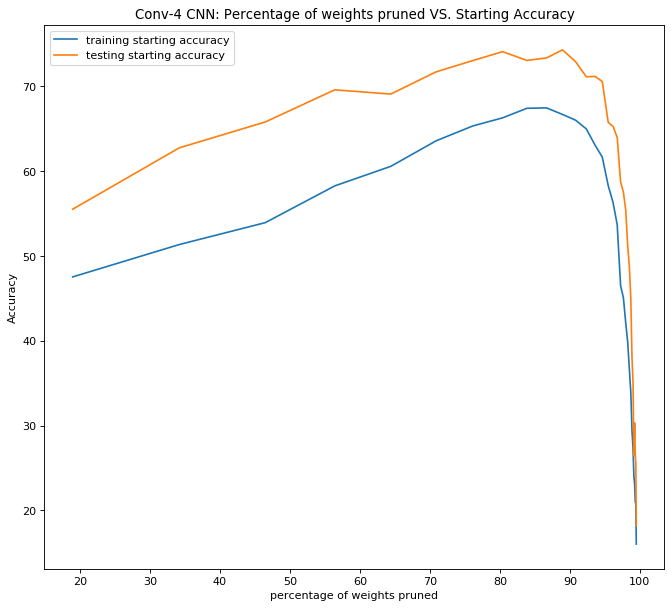

In [76]:
# Visualize starting accuracy VS percentage of weights pruned-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_starting_accuracy.keys()), list(plot_starting_accuracy.values()), label = 'training starting accuracy')
plt.plot(list(plot_starting_test_accuracy.keys()), list(plot_starting_test_accuracy.values()), label = 'testing starting accuracy')

plt.title("Conv-4 CNN: Percentage of weights pruned VS. Starting Accuracy")
plt.xlabel("percentage of weights pruned")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')
plt.show()


In [77]:
# Try to visualize the STARTING training and testing loss VS percentage
# of remaining weights-

# Python 3 dict for visualization-
plot_starting_loss = {}
plot_starting_test_loss = {}

# Key:		percentage of weights pruned
# Value:	starting loss


In [78]:
# Populate 'plot_starting_loss' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_starting_loss[history_main[k]['percentage_wts_pruned']] = history_main[k]['loss'][0]


In [79]:
# Populate 'plot_starting_test_loss' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_starting_test_loss[history_main[k]['percentage_wts_pruned']] = history_main[k]['val_loss'][0]


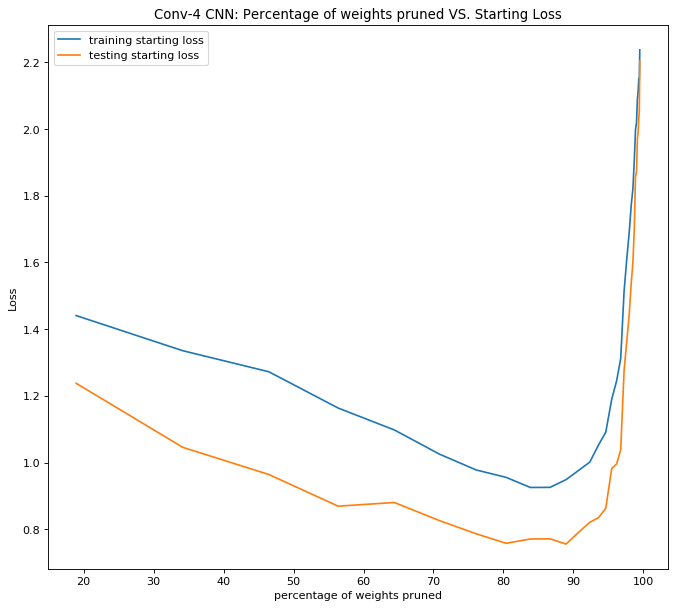

In [80]:
# Visualize Starting training & testing loss VS percentage of weights pruned-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_starting_loss.keys()), list(plot_starting_loss.values()), label = 'training starting loss')
plt.plot(list(plot_starting_test_loss.keys()), list(plot_starting_test_loss.values()), label = 'testing starting loss')

plt.title("Conv-4 CNN: Percentage of weights pruned VS. Starting Loss")
plt.xlabel("percentage of weights pruned")
plt.ylabel("Loss")
plt.legend(loc = 'best')
plt.show()

In [81]:
# Try to visualize: percentage of weights remaining VS BEST accuracy within each iterative
# pruning round

# Python 3 dict for visualization-
plot_best_accuracy = {}
plot_best_test_accuracy = {}

# Key:		percentage of weights pruned
# Value:	best accuracy

In [82]:
# Populate 'plot_best_accuracy' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['accuracy'])
    plot_best_accuracy[history_main[k]['percentage_wts_pruned']] = np.amax(history_main[k]['accuracy'])


In [83]:
# Populate 'plot_best_test_accuracy' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['accuracy'])
    plot_best_test_accuracy[history_main[k]['percentage_wts_pruned']] = np.amax(history_main[k]['val_accuracy'])


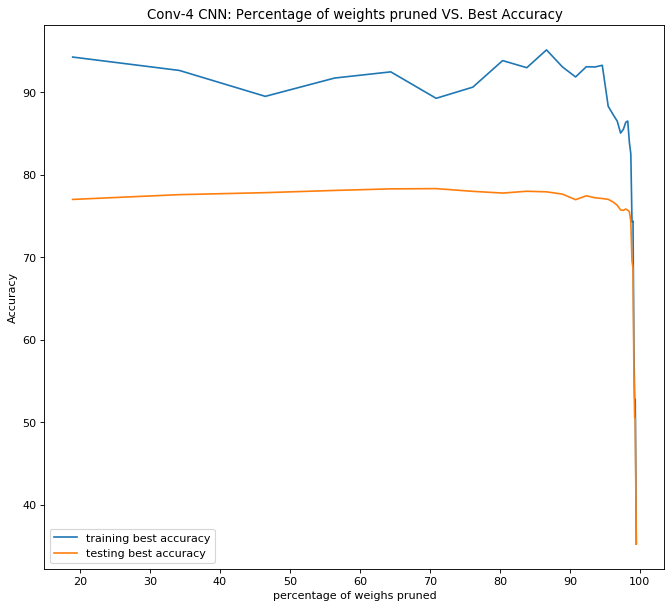

In [84]:
# Visualize best accuracy VS percentage of weights pruned-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_best_accuracy.keys()), list(plot_best_accuracy.values()), label = 'training best accuracy')
plt.plot(list(plot_best_test_accuracy.keys()), list(plot_best_test_accuracy.values()), label = 'testing best accuracy')

plt.title("Conv-4 CNN: Percentage of weights pruned VS. Best Accuracy")
plt.xlabel("percentage of weighs pruned")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')
plt.show()


In [85]:
# Try to visualize: percentage of weights remaining VS LOWEST loss within each iterative
# pruning round

# Python 3 dict for visualization-
plot_best_loss = {}
plot_best_test_loss = {}

# Key:		percentage of weights pruned
# Value:	best loss

In [86]:
# Populate 'plot_best_loss' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_best_loss[history_main[k]['percentage_wts_pruned']] = np.amin(history_main[k]['loss'])


In [87]:
# Populate 'plot_best_test_loss' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_best_test_loss[history_main[k]['percentage_wts_pruned']] = np.amin(history_main[k]['val_loss'])


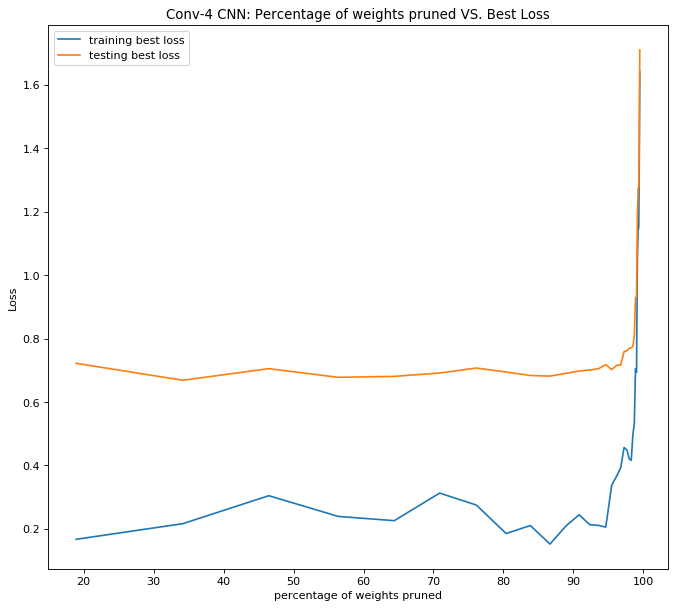

In [88]:
# Visualize best loss VS percentage of weights pruned-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_best_loss.keys()), list(plot_best_loss.values()), label = 'training best loss')
plt.plot(list(plot_best_test_loss.keys()), list(plot_best_test_loss.values()), label = 'testing best loss')

plt.title("Conv-4 CNN: Percentage of weights pruned VS. Best Loss")
plt.xlabel("percentage of weights pruned")
plt.ylabel("Loss")
plt.legend(loc = 'best')
plt.show()
